In [26]:
import os
import datetime
import random
import csv

import PIL
from PIL import Image
from PIL import ImageEnhance

import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.layers import dropout
from tensorflow.contrib.layers import conv2d
from tensorflow.contrib.layers import variance_scaling_initializer
from tensorflow.contrib.layers import batch_norm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# path to dataset 
DATA_ROOT = r"/run/media/onionhuang/HDD/artificial_intelligence/kaggle/dogs-and-cats"
assert(os.path.exists(DATA_ROOT))

TRAIN_DATA = os.path.join(DATA_ROOT, "train")
assert(os.path.exists(TRAIN_DATA))

TEST_DATA = os.path.join(DATA_ROOT, "test")
assert(os.path.exists(TEST_DATA))

In [2]:
def get_label(file_name):
    label = file_name.split(".")[0]
    
    if label == "cat":
        return 0
    elif label == "dog":
        return 1

In [3]:
def get_next_batch(iteration, batch_size, dataset):
    if batch_size * (iteration + 1) > len(dataset):
        return dataset[batch_size*iteration:]
    else:
        return dataset[batch_size*iteration:batch_size*(iteration+1)]

In [4]:
BRIGHTNESS_FACTOR_MIN = 0.1
BRIGHTNESS_FACTOR_MAX = 2

CONTRAST_FACTOR_MIN = 0.1
CONTRAST_FACTOR_MAX = 2

SHARPENESS_FACTOR_MIN = 0
SHARPENESS_FACTOR_MAX = 2

SATURATION_FACTOR_MIN = 0
SATURATION_FACTOR_MAX = 2

def random_enhance_pil(
    image, 
    brightness=True, 
    contrast=True, 
    saturation=True, 
    sharpness=True):
    
    new_image = image
    
    if brightness:
        enhancer = ImageEnhance.Brightness(new_image)
        new_image = enhancer.enhance(random.uniform(BRIGHTNESS_FACTOR_MIN, BRIGHTNESS_FACTOR_MAX))
    
    if contrast:
        enhancer = ImageEnhance.Contrast(new_image)
        new_image = enhancer.enhance(random.uniform(CONTRAST_FACTOR_MIN, CONTRAST_FACTOR_MAX))
    
    if saturation:
        enhancer = ImageEnhance.Color(new_image)
        new_image = enhancer.enhance(random.uniform(SATURATION_FACTOR_MIN, SATURATION_FACTOR_MAX))
    
    if sharpness:
        enhancer = ImageEnhance.Sharpness(new_image)
        new_image = enhancer.enhance(random.uniform(SHARPENESS_FACTOR_MIN, SHARPENESS_FACTOR_MAX))
    
    return new_image

In [5]:
def resize_image_pil(
    image, 
    size, 
    random_enhance=True,
    pad=True, 
    resample_filter=PIL.Image.LANCZOS):
    
    if random_enhance:
        image = random_enhance_pil(image)
    
    width, height = image.size
    
    if height > width:
        new_height = size
        ratio = new_height / height
        new_width = int(width * ratio)
    
    elif width > height:
        new_width = size
        ratio = new_width / width
        new_height = int(height * ratio)
    
    else:
        new_width = size
        new_height = size
        
    image_resize = image.resize((new_width, new_height), resample=resample_filter)
    
    if pad:
        image_pad = Image.new("RGB", (size, size), (0, 0, 0))
        ulc = ((size - new_width) // 2, (size - new_height) // 2)

        image_pad.paste(image_resize, ulc)

        return image_pad
    else:
        return image_resize

In [6]:
def image_to_nparray_pil(image):
    return np.array(image.getdata()).reshape((SIZE, SIZE, 3)) 

In [7]:
def image_to_float_pil(image):
    return image.astype(float) / 255.0

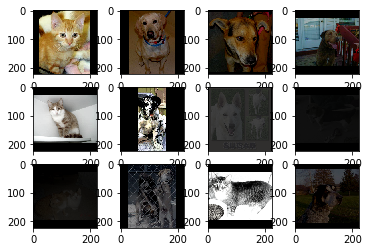

In [8]:
# ImageNet Models Compatibility
SIZE = 224

files = [os.path.join(TRAIN_DATA, os.listdir(TRAIN_DATA)[i]) for i in range(12)]

fig = plt.figure()

for index, file in enumerate(files):
    image = Image.open(file)
    
    image = resize_image_pil(image, SIZE)
    image = (image_to_nparray_pil(image).astype(float)) / 255.0
    
    y = fig.add_subplot(3, 4, index+1)
    y.imshow(image)
    
plt.show()

In [9]:
def random_enhance_tf(image, brightness=True, contrast=True, saturation=True):
    new_image = image
    
    if brightness:
        seed = datetime.datetime.now().second
        new_image = tf.image.random_brightness(new_image, 5, seed=seed)
    
    if contrast:
        seed = datetime.datetime.now().second
        new_image = tf.image.random_contrast(new_image, 0.1, 1.5, seed=seed)
    
    if saturation:
        seed = datetime.datetime.now().second
        new_image = tf.image.random_saturation(new_image, 0., 1.5, seed=seed)
    
    return new_image

def random_flip_tf(image, vertical=True, horizontal=True):
    new_image = image
    
    if vertical:
        seed = datetime.datetime.now().second
        new_image = tf.image.random_flip_up_down(new_image, seed=seed)
    
    if horizontal:
        seed = datetime.datetime.now().second
        new_image = tf.image.random_flip_left_right(new_image, seed=seed)
    
    return new_image

In [ ]:
files = tf.train.match_filenames_once([TRAIN_IMAGES+"/*"] * 2)
    "\n",
    "# files = tf.random_shuffle(files)\n",
    "\n",
    "# print(TRAIN_IMAGES+\"/*\")\n",
    "# \n",
    "labels = tf.map_fn(lambda x: _labels_files(x, TRAIN_MASKS), files)\n",
    "# labels = tf.string_split(files, \"/\")\n",
    "\n",
    "# test = tf.string_split([\"test test\"], \" \")\n",
    "# test_values = test.values\n",
    "\n",
    "sess = tf.InteractiveSession()\n",
    "\n",
    "tf.global_variables_initializer().run()\n",
    "tf.local_variables_initializer().run()\n",
    "\n",
    "# print(test_values.eval())\n",
    "\n",
    "print(files.eval()[:5])\n",
    "# print(len(files.eval()))\n",
    "\n",
    "print(labels.eval()[:5])\n",
    "\n",
    "features_dataset = files.eval()\n",
    "labels_dataset = labels.eval()\n",
    "\n",
    "for index, file in enumerate(features_dataset):\n",
    "    basename = os.path.splitext(os.path.basename(file))[0]\n",
    "    \n",
    "    assert(basename in labels_dataset[index])\n",
    "# print(len(labels.eval()).value)\n",
    "print(\"finish\")\n",
    "sess.close()"


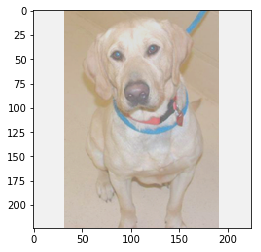

In [10]:
images = []

for file in files:
    image = Image.open(file)
    image = resize_image_pil(image, SIZE)
    images.append(image)
    
images = [image_to_nparray_pil(image) for image in images]

tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, SIZE, SIZE, 3])

x_rand = tf.map_fn(lambda img: random_enhance_tf(img), x)

x_float = tf.image.convert_image_dtype(x_rand, tf.float32)

init_op = tf.global_variables_initializer()

sess = tf.InteractiveSession()

init_op.run()

plt.imshow(image_to_float_pil(x_float.eval(feed_dict={x:images})[1]))
plt.show()

sess.close()

In [11]:
# ImageNet Models Compatibility
SIZE = 224

WIDTH = SIZE
HEIGHT = SIZE

In [12]:
# n_inputs = MNIST.train.images[0].size
n_outputs = 2

# parameters of convolution layers
n_filters = [64, 64, 64]
n_kernel_size = [7, 5, 3]
n_strides = [2, 2, 2]

# n_filters = [64, 64, 64, 64, 64, 64]
# n_kernel_size = [7, 7, 5, 5, 3, 3]
# n_strides = [1, 2, 1, 2, 1, 2]

# parameters of fully connected layers
keep_prob = 0.5
n_neurons = [1024]

# parameters of optimizer
learning_rate = 0.01

In [13]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 3])
y = tf.placeholder(tf.int32, [None])
is_training = tf.placeholder(tf.bool, shape=())

layer = x

# layer = tf.map_fn(lambda img: random_flip_tf(img, vertical=False, horizontal=True), layer)

layer = tf.cond(
    is_training, 
    lambda: tf.map_fn(lambda img: random_flip_tf(img, vertical=False, horizontal=True), layer),
    lambda: layer,
)

layer = tf.image.convert_image_dtype(layer, tf.float32)

# layer = tf.map_fn(lambda img: tf.image.per_image_standardization(img), layer)

# layer = tf.nn.local_response_normalization(layer)

index = 0
for filters, kernel_size, stride in zip(n_filters, n_kernel_size, n_strides):
    layer = conv2d(
        layer, 
        filters, 
        kernel_size, 
        stride, 
        padding="SAME",
#         activation_fn=tf.nn.relu, # use relu activation function
        activation_fn=tf.nn.elu,
        normalizer_fn=batch_norm, # use batch normalization
        normalizer_params={
            "is_training": is_training,
            "decay": 0.99,
            "updates_collections": None,
        },
        weights_initializer=variance_scaling_initializer(), # use he initializer
        scope="conv-{}".format(index),
    )
    
#     layer = tf.nn.local_response_normalization(layer)
    
    index += 1
    
# layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

layer = tf.nn.avg_pool(layer, ksize=[1, 4, 4, 1], strides=[1, 2, 2, 1], padding="SAME")
    
layer = tf.reshape(layer, [-1, 7 * 7 * 4 * n_filters[-1]])

layer = dropout(
    layer,
    keep_prob,
    is_training=is_training,
    scope="drop-to-fc",
)
    
index = 0
for neurons in n_neurons:
    layer = fully_connected(
        layer, 
        neurons,
        activation_fn=tf.nn.elu, # use elu activation function
        normalizer_fn=batch_norm, # use batch normalization
        normalizer_params={
            "is_training": is_training,
            "decay": 0.99,
            "updates_collections": None,
        },
        weights_initializer=variance_scaling_initializer(), # use he initializer
        scope="fc-{}".format(index),
    )
    
    layer = dropout(
        layer,
        keep_prob,
        is_training=is_training,
        scope="drop-{}".format(index),
    )
    
    index += 1
    
logits = fully_connected(
    layer,
    n_outputs,
    activation_fn=None,
    normalizer_fn=batch_norm, # use batch normalization
    normalizer_params={
        "is_training": True,
        "decay": 0.99,
        "updates_collections": None,
    },
    weights_initializer=variance_scaling_initializer(), # use he initializer
    scope="output",
)

probability = tf.nn.softmax(logits)
predict = tf.argmax(probability, axis=1)

# calculate cross entropy and loss
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)

loss_summary = tf.summary.scalar("loss", loss)

# use AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# minimizing the loss in training op
training_op = optimizer.minimize(loss)

# accuracy monitoring
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

accuracy_summary = tf.summary.scalar("accuracy", accuracy)

# initializer for all variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

now = datetime.datetime.utcnow().strftime("%Y%m%d%H%M%S")
LOG_DIR = "logs/{}/".format(now)

summary_writer = tf.summary.FileWriter(LOG_DIR, tf.get_default_graph())


In [15]:
n_epochs = 100
batch_size = 5

# runing the graph
with tf.Session() as sess:

    # we need to initialize all variables first
    init.run()
    
#     saver.restore(sess, "./my-convnet.ckpt")

    for epoch in range(n_epochs):
        
        DATASETS = np.random.permutation([os.path.join(TRAIN_DATA, i) for i in os.listdir(TRAIN_DATA)])

        for iteration in range(len(DATASETS) // batch_size):

            # get mini bath of training data
            next_batch = get_next_batch(
                batch_size=batch_size, 
                iteration=iteration, 
                dataset=DATASETS)
            
            x_batch = []
            
            for file in next_batch:
                image = Image.open(file)
                image = resize_image_pil(image, SIZE)
                x_batch.append(image)

            x_batch = [image_to_nparray_pil(image) for image in x_batch]
        
            y_batch = np.array([get_label(os.path.basename(i)) for i in next_batch])

            _, loss_log, accuracy_log = sess.run(
                [
                    training_op,
                    loss_summary,
                    accuracy_summary,
                ], 
                feed_dict={
                    x: x_batch, 
                    y: y_batch, 
                    is_training: True,
                }
            )
    
            step = epoch * (len(DATASETS) // batch_size) + iteration
            summary_writer.add_summary(loss_log, step)
            summary_writer.add_summary(accuracy_log, step)

#             print(epoch, iteration)
    
            if iteration % 100 == 0:
                saver.save(sess, "./my-convnet.ckpt")

INFO:tensorflow:Restoring parameters from ./my-convnet.ckpt
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174


KeyboardInterrupt: 

In [30]:
batch_size = 5

results = {}

with tf.Session() as sess:

    # we need to initialize all variables first
    init.run()
    
    saver.restore(sess, "../ml_engine/logs/checkpoint_499500.ckpt")
        
    DATASETS = sorted([os.path.join(TEST_DATA, i) for i in os.listdir(TEST_DATA)], 
                      key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))

#     print([os.path.basename(i) for i in DATASETS])

    ids = [os.path.splitext(os.path.basename(i))[0] for i in DATASETS]

    next_batch = DATASETS

    x_batch = []

    for file in next_batch:
        image = Image.open(file)
        image = resize_image_pil(image, SIZE, random_enhance=False)
        x_batch.append(image)

    x_batch = [image_to_nparray_pil(image) for image in x_batch]

    predict_val, probability_val = sess.run(
        [predict, probability], 
        feed_dict={
            x: x_batch, 
            is_training: False,
        }
    )
    
    for index, image_id in enumerate(ids):
        results[image_id] = probability_val[index][1]

with open("classification.csv", "w", newline="") as f:
    writer = csv.writer(
        f, 
        delimiter=",",
        quotechar="|", 
        quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(["id", "label"])
    
    for key, value in results.items():
        writer.writerow([str(key), str(value)])
        
print("FINISH!!")

INFO:tensorflow:Restoring parameters from ./my-convnet.ckpt
FINISH!!
